<font size="8">**Model Analysis**</font>


*Néstor Bravo Egea with NIU = 1563318*

*Juan Manuel Sánchez Melián with NIU = 1598286*

*Jose Carlos Sanz Tirado  with NIU = 1742458*

*Biel with NIU = 1598286*

<font size="6">**Introduction**</font>

The goal of this report is to explain how we have manufactured a Machine Learning(ML) model based in a "Quiniela" game for the football matches in a certain matchday of the spanish football league "La Liga". This model will respond take as an input a dataframe with the list of matches in a certain matchday and its output will be a predcition on the winner for this matches("1" of the home team wins, "X" if there is a tie and "2" if the away team wins) based on the logic and training of the model.

<font size="6">**Features**</font>

As any ML model the main factor between a good model or a bad one are the features of that model.

In our case, we have chosen some features that by our own , maybe naive, guess we think that are significant. They are the following:

- "win_punct" and "lost_punct" : these 2 are coeficients that are calculated from the results of the previous matches between these 2 teams. The coeficients are modulated by a function giving more importance to the previous machthes of recent seasons. The function that modulates this is $1 / ((currentseason - season)^2 + 1)$. As we have already seen and it can be computed easily this function has a maximum in currentseason and it decreases as seasons increase.

- "points_relative_index" : this feature is just the difference of points between the 2 teams up to that matchday. Then, this difference is also modulated by a function that gives it more importance as matchdays goes by. It is not the same a 9 points difference in the first matchday than in the last one. The function that modulates it is $matchday^{2} / (matchday^{ 2} + 38)$.

- "last5_home" and "last5_away" : just records the results of the last 5 matches played of the home team and the away team, respectively. This is to take into account streaks. Winning the last 5 games radically increases the probability to win the next one.

- "last_season_points_home" and "last_season_points_away" : just stores the amount of points that the home team and the away team reached the last season, respectively. For teams that switch division, the value changes to be the mean of the division.

<font size="6">**Construction of the model**</font>

We will explain step by step our method to construct the model.

In [1]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
)

# Ensure the parent directory is in the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import settings

We need to import all the necessary libraries and our dataframe.

In [2]:
with sqlite3.connect(settings.DATABASE_PATH) as conn:
    df = pd.read_sql(
        f"""
            SELECT * FROM Matches
        """,
        conn,
    )

In [3]:
df = df.dropna(subset=["score"]).copy()
df["home_score"] = df["score"].str.split(":").str[0].astype(int)
df["away_score"] = df["score"].str.split(":").str[1].astype(int)
df["home_win"] = (df["home_score"] > df["away_score"]).astype(int)
df["away_win"] = (df["home_score"] < df["away_score"]).astype(int)
df["tie"] = (df["home_score"] == df["away_score"]).astype(int)
df["difference_score"] = abs(df["home_score"] - df["away_score"])

We construct new columns to have better organisation on the wins and the scores of each team.

In [4]:
df = df.dropna(subset=["score"])
df["season"] = df["season"].str.split("-").str[0].astype(int)

conditions = [(df["home_win"] == 1), (df["tie"] == 1), (df["away_win"] == 1)]

choices = [1, 0, -1]

df["result"] = np.select(conditions, choices, default=None)

We drop the score colum now that we have already the columns "home_score" and "away_score" and we construct the "result" colum. This "result" will be our target later.

In [5]:
def calculate_team_results(df, max_matchday=None):
    """
    Calculates team results up to a specific matchday.
    Has been modified to include just the necessary columns for the model.

    :param df: DataFrame with match data
    :param max_matchday: Only consider matches up to this matchday (exclusive)
    :return: DataFrame with team points
    """
    if max_matchday is not None:
        df = df[df["matchday"] < max_matchday].copy()

    df_results = (
        pd.concat(
            [
                df.groupby(["season", "home_team"])
                .agg(
                    W=("home_win", "sum"),
                    L=("away_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"home_team": "team"}),
                df.groupby(["season", "away_team"])
                .agg(
                    W=("away_win", "sum"),
                    L=("home_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"away_team": "team"}),
            ]
        )
        .groupby(["season", "team"])
        .sum()
        .reset_index()
    )

    df_results["points"] = df_results["W"] * 3 + df_results["T"]

    df_results = df_results.sort_values(
        by=["season", "points"],
        ascending=[False, False],
    ).reset_index(drop=True)

    df_results["rank"] = (
        df_results.groupby(["season"])["points"]
        .rank("first", ascending=False)
        .astype(int)
    )

    df_results = df_results[
        [
            "season",
            "team",
            "points",
        ]
    ]
    return df_results

This is a function extracted from the data science part that will be useful here aswell to calculate results up to one matchday.

In [6]:
def team_confrontations(df, team1, team2):
    """
    Returns the confrontations between two teams

    :param df: DataFrame with match data
    :param team1: First team
    :param team2: Second team
    :return: DataFrame with confrontations between the two teams
    """
    df_confrontations = df.loc[
        ((df["home_team"] == team1) | (df["away_team"] == team1))
        & ((df["home_team"] == team2) | (df["away_team"] == team2))
    ]

    return df_confrontations


def won_games(df, team: str):
    """
    Returns those winning games for a given team

    :param df: DataFrame with match data
    :param team: Team name
    :return: DataFrame with winning games for the team
    """
    home_wins = (df["home_team"] == team) & (df["home_win"] == 1)
    away_wins = (df["away_team"] == team) & (df["away_win"] == 1)
    return df[home_wins | away_wins]


def lost_games(df, team: str):
    """
    Returns those winning games for a given team

    :param df: DataFrame with match data
    :param team: Team name
    :return: DataFrame with winning games for the team
    """
    home_lost = (df["home_team"] == team) & (df["home_win"] == 0)
    away_lost = (df["away_team"] == team) & (df["away_win"] == 0)
    tie_games = (df["home_team"] == team) & (df["tie"] == 1) | (
        df["away_team"] == team
    ) & (df["tie"] == 1)

    return df[(home_lost | away_lost) & ~tie_games]

In [7]:
def win_lost_index(row, df_conf_dict):
    """
    Calculates win and loss punctuation between two teams for the row's season,
    using a precomputed dictionary of relevant confrontations for each season.

    This function returns a victory and lose punctuation between 2 teams.
    It is given by 1 / ((currentseason - season)^2 + 1)
    This function has a maximum in currentseason and it deacreses as season increase
    Giving more importance to recent matches.
    It is symmetric for both teams, so win_team1 = lost_team2.

    :param row: A row from the DataFrame containing "season", "home_team" and "away_team".
    :param df_conf_dict: A dictionary containing relevant confrontations for each season.
    :return: A tuple with the win and loss punctuation for the row's season.
    """
    season = row["season"]
    team1 = row["home_team"]
    team2 = row["away_team"]

    df_conf = df_conf_dict.get((team1, team2), pd.DataFrame())

    df_won = won_games(df_conf, team1)
    if not df_won.empty:
        df_won["win_punct"] = 1 / ((season - df_won["season"].astype(int)) ** 2 + 1)
        win_punct = df_won["win_punct"].sum()
    else:
        win_punct = 0

    df_lost = lost_games(df_conf, team1)
    if not df_lost.empty:
        df_lost["lost_punct"] = 1 / ((season - df_lost["season"].astype(int)) ** 2 + 1)
        lost_punct = df_lost["lost_punct"].sum()
    else:
        lost_punct = 0

    return win_punct, lost_punct


def inform_win_lost_index(df, df_calculate, depth=20):
    """
    Adds win and loss punctuation to the DataFrame for each row's season.

    :param df: DataFrame containing match data for all teams.
    :param df_calculate: DataFrame containing the matches to calculate the win and loss punctuation.
    :return: DataFrame with the win and loss punctuation for each row's season.
    """
    max_season = df_calculate["season"].max()
    df_recent = df[df["season"] >= (max_season - depth)].copy()

    teams = df_calculate[["home_team", "away_team"]].drop_duplicates()
    df_conf_dict = {
        (team1, team2): team_confrontations(df_recent, team1, team2)
        for team1, team2 in zip(teams["home_team"], teams["away_team"])
    }

    df_calculate[["win_punct", "lost_punct"]] = df_calculate.apply(
        lambda row: win_lost_index(row, df_conf_dict), axis=1, result_type="expand"
    )

    return df_calculate

These functions are used to create the features we explained before "win_punct" and "lose_punct".

In [8]:
def difference_points(row, df_results_dict):
    """
    Calculates the difference in points between home and away teams
    considering only matches before the current matchday.

    :param row: DataFrame row with home_team, away_team, season, and matchday
    :param df_results_dict: Dictionary of {season: {matchday: results_df}}
    :return: Point difference between home and away team
    """
    season = row["season"]
    matchday = row["matchday"]

    results_key = (season, matchday)
    if results_key not in df_results_dict:
        return 0

    results_df = df_results_dict[results_key]

    try:
        home_team_points = results_df.loc[
            results_df["team"] == row["home_team"], "points"
        ].iloc[0]
        away_team_points = results_df.loc[
            results_df["team"] == row["away_team"], "points"
        ].iloc[0]
        return home_team_points - away_team_points
    except (KeyError, IndexError):
        return 0


def inform_relatives_points(df, df_calculate):
    """
    Calculates relative points for each match considering only previous matchdays.

    :param df: Complete DataFrame with all matches
    :param df_calculate: DataFrame with matches to calculate features for
    :return: DataFrame with added relative points features
    """
    df_results_dict = {}

    for season in df_calculate["season"].unique():
        season_data = df[df["season"] == season].copy()

        for matchday in df_calculate[df_calculate["season"] == season][
            "matchday"
        ].unique():
            results = calculate_team_results(season_data, max_matchday=matchday)
            df_results_dict[(season, matchday)] = results

    df_calculate["points_relative"] = df_calculate.apply(
        lambda row: difference_points(row, df_results_dict), axis=1
    )

    
 
    df_calculate["points_relative_index"] = df_calculate.apply(
        lambda row: row["points_relative"]
        * (row["matchday"] ** 2 / (row["matchday"] ** 2 + 38))
        if row["matchday"] > 0
        else 0,
        axis=1,
    )


    return df_calculate

    

These ones are to create the feature "points_relative_index".

In [9]:
def calculate_results(df):
    """
    Precalculates results for all matches.

    :param df: DataFrame with match data
    :return: DataFrame with results for all matches
    """
    home_results = df[["matchday", "season", "home_team", "home_win", "tie"]].copy()
    home_results["team"] = home_results["home_team"]
    home_results["Result"] = np.where(
        home_results["tie"] == 1, "T", np.where(home_results["home_win"] == 1, "W", "L")
    )

    away_results = df[["matchday", "season", "away_team", "away_win", "tie"]].copy()
    away_results["team"] = away_results["away_team"]
    away_results["Result"] = np.where(
        away_results["tie"] == 1, "T", np.where(away_results["away_win"] == 1, "W", "L")
    )

    all_results = pd.concat(
        [
            home_results[["matchday", "season", "team", "Result"]],
            away_results[["matchday", "season", "team", "Result"]],
        ]
    ).sort_values(["team", "season", "matchday"], ascending=[True, True, False])

    return all_results


def get_last_5_results(all_results, matchday, team, season):
    """
    Gets all available results up to 5 for a team in a season.

    :param all_results: DataFrame with all results
    :param matchday: Current matchday
    :param team: Team name
    :param season: Season
    :return: Tuple with the last 5 results and the number of matches
    """
    mask = (
        (all_results["team"] == team)
        & (all_results["season"] == season)
        & (all_results["matchday"] < matchday)
    )

    results = all_results[mask]["Result"].head(5).tolist()
    return results, len(results)


def convert_results_to_points(results_tuple):
    """
    Converts results to points with correction factor for fewer than 5 matches.
    The correction factor is 5 / num_matches.

    :param results_tuple: Tuple with results and number of matches
    :return: Corrected points
    """
    results, num_matches = results_tuple
    if num_matches == 0:
        return 0

    points_map = {"W": 3, "L": 0, "T": 1}
    total_points = sum(points_map[result] for result in results)

    correction_factor = 5 / num_matches
    corrected_points = total_points * correction_factor

    return round(corrected_points, 2)


def last5index(df, df_predict):
    """
    Calculates the last 5 matches index for all teams with correction for fewer matches.

    :param df: DataFrame with all matches
    :param df_predict: DataFrame with matches to calculate features for
    :return: DataFrame with added last 5 matches index features
    """
    # df_calculate has the last 5 matches results so takes the same season as df_predict and the matchday is less than the matchday of the match to predict
    df_calculate = df.loc[
        (df["season"] == df_predict["season"].max())
        & (df["matchday"] < df_predict["matchday"].max())
        & (df["matchday"] >= df_predict["matchday"].max() - 5)
    ].copy()

    all_results = calculate_results(df_calculate)

    df_predict["last5_home"] = df_predict.apply(
        lambda row: get_last_5_results(
            all_results, row["matchday"], row["home_team"], row["season"]
        ),
        axis=1,
    )

    df_predict["last5_away"] = df_predict.apply(
        lambda row: get_last_5_results(
            all_results, row["matchday"], row["away_team"], row["season"]
        ),
        axis=1,
    )
    df_predict["last5_home"] = df_predict["last5_home"].apply(convert_results_to_points)
    df_predict["last5_away"] = df_predict["last5_away"].apply(convert_results_to_points)

    return df_predict

These functions to calculate the last 5 matches of the home team and away team.

In [10]:
def last_season_position(df, df_predict):
    """
    Adds the last season points in a new column.
    If a team was not in the last season, the average of the last season minus 20 is used.

    :param df: DataFrame with all matches
    :param df_predict: DataFrame with matches to calculate features for
    :return: DataFrame with added last season points
    """
    df_calculate = df.loc[(df["season"] == df_predict["season"].max() - 1)].copy()
    df_results = calculate_team_results(df_calculate)

    df_predict["last_season_points_home"] = df_predict.apply(
        lambda row: df_results.loc[
            df_results["team"] == row["home_team"], "points"
        ].iloc[0]
        if row["home_team"] in df_results["team"].values
        else 0,
        axis=1,
    )

    df_predict["last_season_points_away"] = df_predict.apply(
        lambda row: df_results.loc[
            df_results["team"] == row["away_team"], "points"
        ].iloc[0]
        if row["away_team"] in df_results["team"].values
        else 0,
        axis=1,
    )

    # Improvement, calcualte mean of the teams that ascend to the league
    df_predict["last_season_points_home"] = df_predict[
        "last_season_points_home"
    ].replace(0, df_results["points"].mean() - 20)
    df_predict["last_season_points_away"] = df_predict[
        "last_season_points_away"
    ].replace(0, df_results["points"].mean() - 20)
    return df_predict




This functions to calculate the points of last season.

From all the data we have we have selected these especifically to testo the accuracy of the model.

## Pretreatment

In [11]:
# Data that will be used for training
train_season = 2019
depth = 10  # Number of seasons to consider for training

df_train = df.loc[
    (df["season"] > (train_season - depth)) & (df["season"] <= train_season)
].copy()

df_train = inform_relatives_points(df, df_train)
print("Relative points calculated")
df_train = inform_win_lost_index(df, df_train)
print("Win and loss index calculated")
df_train = last5index(df, df_train)
print("Last 5 index calculated")
df_train = last_season_position(df, df_train)
print("Last season position calculated")

Relative points calculated
Win and loss index calculated
Last 5 index calculated
Last season position calculated


We apply all our functions to the dataframe we want to study and now we have the features we want and we can train the model and test it. We will use the Gradient Boosting Classifier method.

## Train

In [12]:
features = [
    "win_punct",
    "lost_punct",
    "points_relative_index",
    "last5_home",
    "last5_away",
    "last_season_points_home",
    "last_season_points_away",
]
target = "result"

x_train = df_train[features]
y_train = df_train[target]

le = LabelEncoder()
y_train = le.fit_transform(y_train)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=40
)

clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)

y_val_pred = clf.predict(x_val)
validation_accuracy = (y_val_pred == y_val).mean()
print(f"Validation Accuracy: {validation_accuracy:.2%}")

# Save the model
model_name = "model2-11-20s-7f.pkl"
joblib.dump(clf, f"../models/{model_name}.pkl")



Validation Accuracy: 72.33%


['../models/model2-11-20s-7f.pkl.pkl']

Here we check the accuracy of our model. Choosing 10 season to train we reach a very good accuracy of 72 %. This is extremely high considering football is a very unpredictible game. We can test how the accuracy changes with respect to the depth and do a plot.

Depth 30 - Validation Accuracy: 63.94%
Depth 20 - Validation Accuracy: 71.02%
Depth 5 - Validation Accuracy: 69.83%
Depth 10 - Validation Accuracy: 72.33%


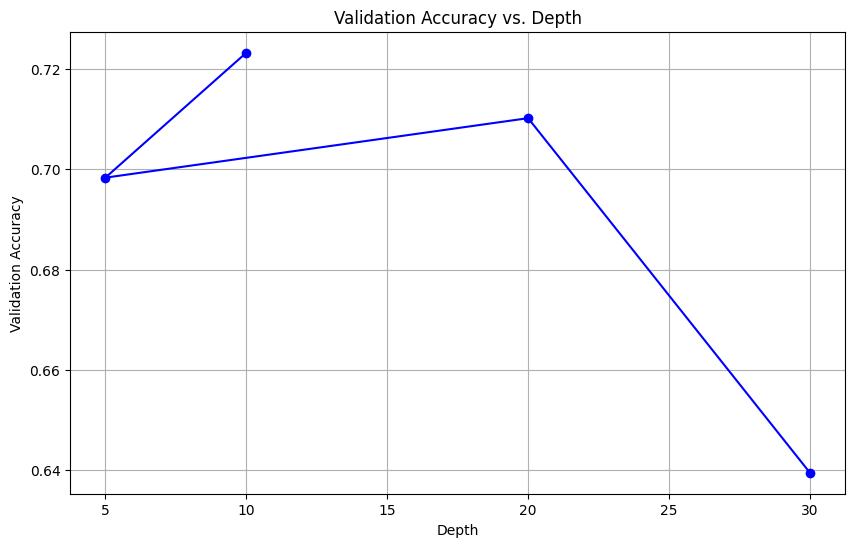

In [ ]:
depths = [30, 20, 5, 10]
validation_accuracies = []

for depth in depths:
    df_train = df.loc[
        (df["season"] > (train_season - depth)) & (df["season"] <= train_season)
    ].copy()
    
    df_train = inform_relatives_points(df, df_train)
    df_train = inform_win_lost_index(df, df_train)
    df_train = last5index(df, df_train)
    df_train = last_season_position(df, df_train)   
    x_train = df_train[features]
    y_train = df_train[target]
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, test_size=0.1, random_state=40
    )
    
    clf = GradientBoostingClassifier()
    clf.fit(x_train, y_train)
    y_val_pred = clf.predict(x_val)
    validation_accuracy = (y_val_pred == y_val).mean()
    validation_accuracies.append(validation_accuracy)
    print(f"Depth {depth} - Validation Accuracy: {validation_accuracy:.2%}")



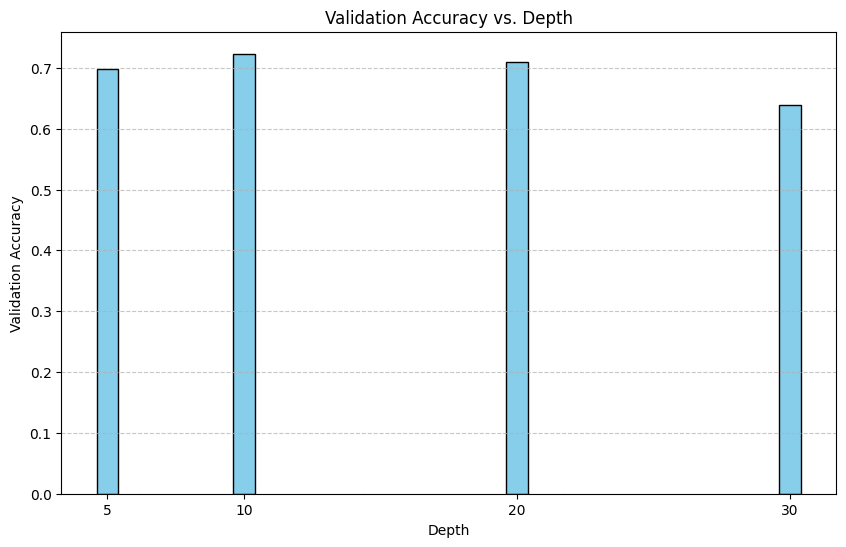

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(depths, validation_accuracies, color='skyblue', edgecolor='black')
plt.xlabel("Depth")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Depth")
plt.xticks(depths) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()

We can see here that there is a maximum with a dataframe using the last 10 seasons. It seems that this value is the sweet spot that makes the data to have enough historical value and enough recency so that the historical matches between 2 teams are significant.

## Performance

=== Model Performance Analysis ===



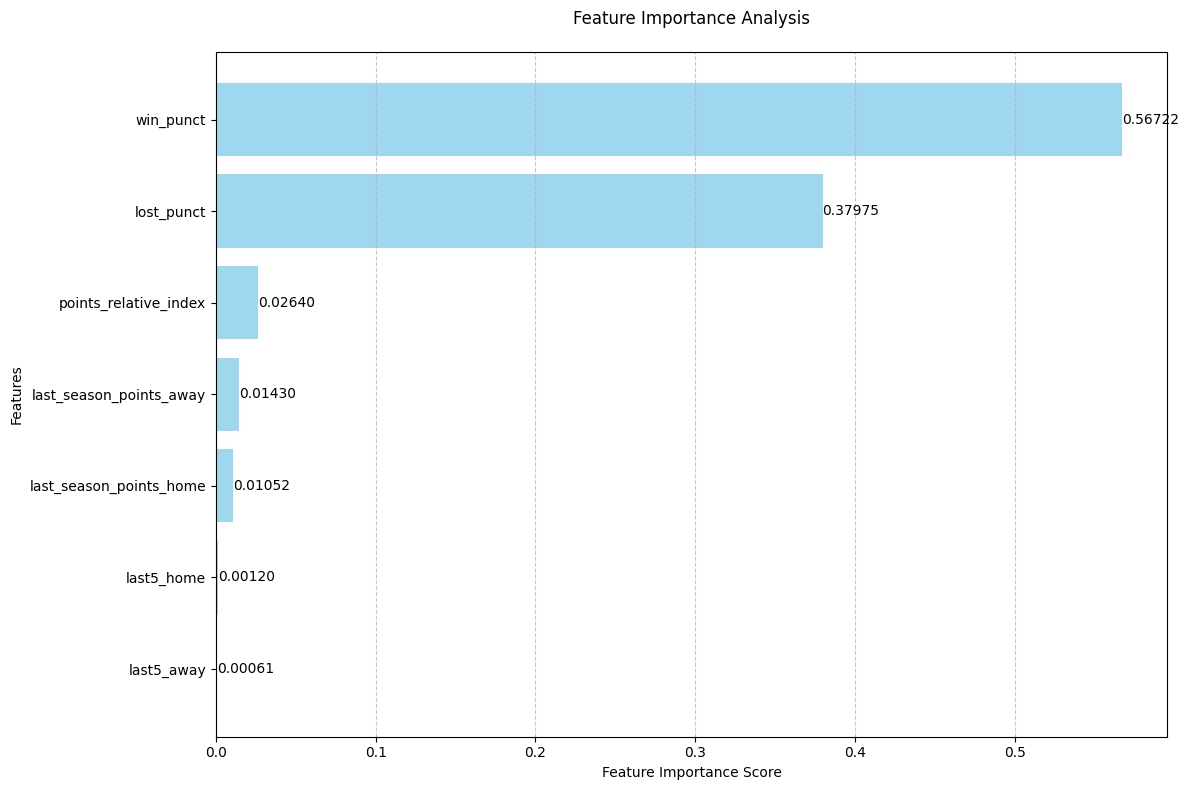

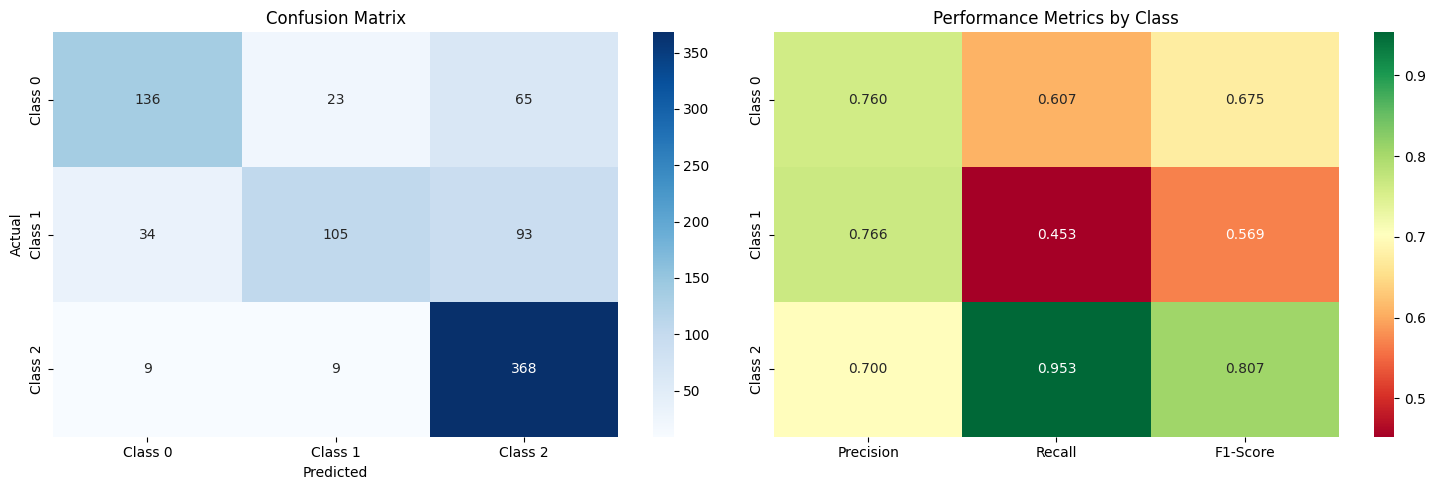


Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.76      0.61      0.67       224
     Class 1       0.77      0.45      0.57       232
     Class 2       0.70      0.95      0.81       386

    accuracy                           0.72       842
   macro avg       0.74      0.67      0.68       842
weighted avg       0.73      0.72      0.71       842


Overall Model Accuracy: 0.723


In [14]:
def plot_feature_importance(feature_importance, figsize=(12, 8)):
    """
    Creates an enhanced feature importance visualization

    :param feature_importance: DataFrame with feature importance values
    :param figsize: Figure size
    """
    plt.figure(figsize=figsize)

    bars = plt.barh(
        feature_importance["feature"],
        feature_importance["importance"],
        color="skyblue",
        alpha=0.8,
    )

    for bar in bars:
        width = bar.get_width()
        plt.text(
            width,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.5f}",
            ha="left",
            va="center",
            fontsize=10,
        )

    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Feature Importance Analysis", pad=20)

    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix_analysis(y_true, y_pred, clf, figsize=(15, 5)):
    """
    Creates a comprehensive confusion matrix analysis with metrics

    :param y_true: True labels
    :param y_pred: Predicted labels
    :param clf: Classifier used for prediction
    :param figsize: Figure size
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    classes = clf.classes_
    class_names = [
        f"Class {c}" if isinstance(c, (int, np.integer)) else str(c) for c in classes
    ]

    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax1,
    )
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    ax1.set_title("Confusion Matrix")

    metrics_data = pd.DataFrame(
        {"Precision": precision, "Recall": recall, "F1-Score": f1}, index=class_names
    )

    sns.heatmap(metrics_data, annot=True, fmt=".3f", cmap="RdYlGn", ax=ax2)
    ax2.set_title("Performance Metrics by Class")


    plt.tight_layout()
    plt.show()

    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


def analyze_model_performance(feature_importance, y_true, y_pred, clf):
    """
    Performs comprehensive model analysis

    :param feature_importance: DataFrame with feature importance values
    :param y_true: True labels
    :param y_pred: Predicted labels
    :param clf: Classifier used for prediction
    """
    print("=== Model Performance Analysis ===\n")

    plot_feature_importance(feature_importance)
    plot_confusion_matrix_analysis(y_true, y_pred, clf)

    accuracy = (y_true == y_pred).mean()
    print(f"\nOverall Model Accuracy: {accuracy:.3f}")


feature_importance = pd.DataFrame(
    {
        "feature": features,
        "importance": clf.feature_importances_,
    }
)
feature_importance = feature_importance.sort_values("importance", ascending=False)
analyze_model_performance(feature_importance, y_val, y_val_pred, clf)

Here we can see which features are the most important ones in our model, being this one "win_punct", followed closely by "lost_punct". It seems that we have our system's accuracy rely a lot on this feature and this is why our model is so exact. It seems that the function we used to modelate these two indexes really encapsulated some real behaviour of winning teams.

## Example of usage

If we now want to use it to properly predict one matchday and see the precision of a single matchday we can do the following

In [15]:
model_path = "../models/model2-11-20s-7f.pkl"

if os.path.exists(model_path):
    clf = joblib.load(model_path)
else:
    print(
        f"Model file not found at {model_path}, uncomment the previous cell to train the model"
    )

Model file not found at ../models/model2-11-20s-7f.pkl, uncomment the previous cell to train the model


In [16]:
season_to_predict = 2020
matchday_to_predict = 34

df_predict = df.loc[
    (df["season"] == season_to_predict)
    & (df["matchday"] == matchday_to_predict)
    & (df["division"] == 1)
].copy()

df_predict = inform_relatives_points(df, df_predict)
df_predict = inform_win_lost_index(df, df_predict)
df_predict = last5index(df, df_predict)
df_predict = last_season_position(df, df_predict)
x_predict = df_predict[features]

y_predict = clf.predict(x_predict)
y_predict = le.inverse_transform(y_predict)
df_predict["prediction"] = y_predict
df_predict["correct"] = df_predict["result"] == df_predict["prediction"]
print(df_predict["correct"].sum() / df_predict.shape[0] * 100)

df_predict

60.0


,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,...,points_relative,points_relative_index,win_punct,lost_punct,last5_home,last5_away,last_season_points_home,last_season_points_away,prediction,correct
25768,2020,1,34,4/30/21,9:00 PM,Celta de Vigo,Levante,2:0,2,0,...,3,2.904523,1.573258,1.233273,7.0,3.0,37,49,1,True
25769,2020,1,34,5/1/21,2:00 PM,SD Eibar,Alavés,3:0,3,0,...,-8,-7.745394,1.360118,2.113222,0.0,8.0,42,39,-1,False
25770,2020,1,34,5/1/21,4:15 PM,Elche CF,Atlético Madrid,0:1,0,1,...,-43,-41.631491,0.005256,2.599310,5.0,7.0,61,70,-1,True
25771,2020,1,34,5/1/21,6:30 PM,SD Huesca,Real Sociedad,1:0,1,0,...,-26,-25.172529,1.000000,1.221990,6.0,8.0,70,56,1,True
25772,2020,1,34,5/1/21,9:00 PM,Real Madrid,CA Osasuna,2:0,2,0,...,31,30.013400,2.244873,0.026085,11.0,10.0,87,52,1,True
25773,2020,1,34,5/2/21,2:00 PM,Real Valladolid,Real Betis,1:1,1,1,...,-20,-19.363484,1.212978,1.288182,3.0,5.0,42,41,1,False
25774,2020,1,34,5/2/21,4:15 PM,Villarreal,Getafe,1:0,1,0,...,15,14.522613,3.239531,0.393831,6.0,5.0,60,54,1,True
25775,2020,1,34,5/2/21,6:30 PM,Granada CF,Cádiz CF,0:1,0,1,...,8,7.745394,0.100000,1.100000,9.0,8.0,56,69,0,False
25776,2020,1,34,5/2/21,9:00 PM,Valencia,Barcelona,2:3,2,3,...,-35,-33.886097,0.577250,1.881345,3.0,9.0,53,82,0,False
25777,2020,1,34,5/3/21,9:00 PM,Sevilla FC,Athletic,0:1,0,1,...,28,27.108878,1.010465,2.506395,15.0,7.0,70,51,-1,True


In [17]:
df_predict_quiniela = df_predict[
    ["season", "matchday", "home_team", "away_team", "result", "prediction", "correct"]
].copy()
def quiniela_format(df):
    df["result"] = df["result"].map({1: "1", 0: "X", -1: "2"})
    df["prediction"] = df["prediction"].map({1: "1", 0: "X", -1: "2"})
    return df

df_predict_quiniela = quiniela_format(df_predict_quiniela)
df_predict_quiniela

,season,matchday,home_team,away_team,result,prediction,correct
25768,2020,34,Celta de Vigo,Levante,1,1,True
25769,2020,34,SD Eibar,Alavés,1,2,False
25770,2020,34,Elche CF,Atlético Madrid,2,2,True
25771,2020,34,SD Huesca,Real Sociedad,1,1,True
25772,2020,34,Real Madrid,CA Osasuna,1,1,True
25773,2020,34,Real Valladolid,Real Betis,X,1,False
25774,2020,34,Villarreal,Getafe,1,1,True
25775,2020,34,Granada CF,Cádiz CF,2,X,False
25776,2020,34,Valencia,Barcelona,2,X,False
25777,2020,34,Sevilla FC,Athletic,2,2,True
